In [22]:
from PIL import Image

img = Image.open("data/RAF-DB/DATASET/train/1/train_00010_aligned.jpg")
print(img.size)  # (width, height)

(100, 100)


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [36]:
# ============================================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================================


class RAFDBDataset(torch.utils.data.Dataset):
    """Load RAF-DB dataset with numbered folders and CSV labels"""

    def __init__(self, data_dir, labels_file, transform=None):
        import pandas as pd

        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # RAF-DB emotion mapping (your label order): 1=surprised, 2=fearful, 3=disgusted, 4=happy, 5=sad, 6=angry, 7=neutral
        self.emotion_map = {
            0: "surprised",
            1: "fearful",
            2: "disgusted",
            3: "happy",
            4: "sad",
            5: "angry",
            6: "neutral",
        }

        # Load labels from CSV
        df = pd.read_csv(labels_file)
        print(f"Loaded {len(df)} entries from CSV")

        # Load image paths and labels from CSV
        for _, row in df.iterrows():
            img_name = row.iloc[0]  # First column: image name
            label_num = int(row.iloc[1])  # Second column: emotion label (1-7)
            label_idx = label_num - 1  # Convert to 0-indexed (0-6)

            # Construct full path: data_dir/1/image_name or data_dir/2/image_name, etc.
            # RAF-DB structure: numbered folders contain images
            for folder in sorted(os.listdir(data_dir)):
                folder_path = os.path.join(data_dir, folder)
                if not os.path.isdir(folder_path):
                    continue

                img_path = os.path.join(folder_path, img_name)
                if os.path.exists(img_path):
                    self.images.append(img_path)
                    self.labels.append(label_idx)
                    break

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


def get_data_transforms():
    """Transforms that upsample 100x100 images to 256x256 for better Grad-CAM"""
    train_transform = transforms.Compose(
        [
            transforms.Resize(
                (256, 256), interpolation=transforms.InterpolationMode.BILINEAR
            ),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize(
                (256, 256), interpolation=transforms.InterpolationMode.BILINEAR
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    return train_transform, val_transform

In [37]:
# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================


class EmotionCNN(nn.Module):
    """Emotion detection model optimized for Grad-CAM visualization"""

    def __init__(self, num_emotions=7):
        super(EmotionCNN, self).__init__()
        self.num_emotions = num_emotions

        # Convolutional blocks - keeping feature maps larger for better Grad-CAM
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 256 -> 128

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 128 -> 64

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)  # 64 -> 32

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_emotions)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [57]:
# ============================================================================
# 3. GRAD-CAM VISUALIZATION
# ============================================================================


def setup_grad_cam(model, target_layer):
    """Initialize Grad-CAM for visualization"""
    # For M3 Mac (Apple Silicon), don't use use_cuda parameter
    grad_cam = GradCAM(model=model, target_layers=[target_layer])
    return grad_cam


def generate_emotion_cam(
    model, image_path, emotion_names, target_layer, true_label=None
):
    """
    Generate Grad-CAM visualization for a single image.

    Args:
        model: Trained emotion detection model
        image_path: Path to input image
        emotion_names: List of emotion class names (from dataset.emotion_map)
        target_layer: Convolutional layer to visualize

    Returns:
        pred_emotion, confidence, cam_heatmap
    """
    # Load and preprocess image
    transform = transforms.Compose(
        [
            transforms.Resize(
                (256, 256), interpolation=transforms.InterpolationMode.BILINEAR
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    # Move to appropriate device (MPS for M3 Mac)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    img_tensor = img_tensor.to(device)
    model = model.to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_emotion = emotion_names[pred_idx]
        confidence = F.softmax(output, dim=1)[0, pred_idx].item()

    # Get true emotion if provided
    true_emotion = emotion_names[true_label] if true_label is not None else None
    is_correct = (pred_idx == true_label) if true_label is not None else None
    # SHOW TRUE AND PREDICTED LABELS
    if true_label is not None:
        print(f"True emotion: {true_emotion} (index: {true_label})")
        print(f"Predicted emotion: {pred_emotion} (index: {pred_idx})")
        print(f"Correct: {'✓' if is_correct else '✗'}")
        print(f"Confidence: {confidence:.2%}")
    else:
        print(f"Predicted emotion: {pred_emotion} (index: {pred_idx})")
        print(f"Confidence: {confidence:.2%}")

    # Generate Grad-CAM
    grad_cam = setup_grad_cam(model, target_layer)
    targets = [ClassifierOutputTarget(pred_idx)]

    try:
        cam = grad_cam(input_tensor=img_tensor, targets=targets)
        cam = cam[0, :]
    finally:
        # Properly clean up grad_cam to avoid AttributeError on M3
        if hasattr(grad_cam, "activations_and_grads"):
            grad_cam.activations_and_grads.release()
        del grad_cam

    # Normalize image for visualization and resize to match CAM
    img_array = np.array(img) / 255.0

    # Resize image to 256x256 to match CAM heatmap size
    img_pil = Image.fromarray(np.uint8(img_array * 255)).resize(
        (256, 256), Image.BILINEAR
    )
    img_array = np.array(img_pil) / 255.0

    # Overlay CAM on image
    visualization = show_cam_on_image(img_array, cam, use_rgb=True)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title("Original Image (upscaled from 100x100)")
    axes[0].axis("off")

    axes[1].imshow(cam, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")
    # Build title for third panel
    if true_label is not None:
        correctness = "✓ Correct" if is_correct else "✗ Incorrect"
        title = f"True: {true_emotion}\nPredicted: {pred_emotion}\nConfidence: {confidence:.2%}\n{correctness}"
        title_color = "green" if is_correct else "red"
    else:
        title = f"Predicted: {pred_emotion}\nRAHHHHConfidence: {confidence:.2%}"
        title_color = "black"

    axes[2].imshow(visualization)
    axes[2].set_title(title, fontsize=11, color=title_color)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return pred_emotion, confidence, cam

In [39]:
# ============================================================================
# 4. TRAINING FUNCTION
# ============================================================================


def train_emotion_model(
    data_dir, labels_file, num_epochs=10, batch_size=32, learning_rate=0.001
):
    """
    Train emotion detection model on RAF-DB dataset.

    Args:
        data_dir: Path to directory containing numbered subfolders (1, 2, 3, etc.)
        labels_file: Path to train_labels.csv file
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer

    Returns:
        model, dataset, emotion_names
    """
    # Use MPS for M3 Mac, CUDA for GPU, CPU as fallback
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}\n")

    # Load data
    train_transform, val_transform = get_data_transforms()
    dataset = RAFDBDataset(data_dir, labels_file, transform=train_transform)

    # Create data loader
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    emotion_names = {v: k for k, v in dataset.emotion_map.items()}
    emotion_names = dict(sorted(emotion_names.items()))
    print(f"Emotions: {list(emotion_names.values())}")
    print(f"Total images: {len(dataset)}\n")

    # Initialize model
    num_emotions = len(dataset.emotion_map)
    model = EmotionCNN(num_emotions=num_emotions)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Stats
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        print(
            f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%"
        )

    print("\nTraining complete!")
    return model, dataset, emotion_names

In [42]:
# ============================================================================
# 5. USAGE EXAMPLE
# ============================================================================

# Set your RAF-DB data directory and labels file
DATA_DIR = "data/RAF-DB/DATASET/train"  # Directory containing folders 1, 2, 3, etc.
LABELS_FILE = "data/RAF-DB/train_labels.csv"  # Your CSV file

# Train model
print("=" * 60)
print("TRAINING EMOTION DETECTION MODEL")
print("=" * 60)
model, dataset, emotion_names_list = train_emotion_model(
    data_dir=DATA_DIR,
    labels_file=LABELS_FILE,
    num_epochs=30,  # CHANGE EPOCHS
    batch_size=32,
    learning_rate=0.001,
)

TRAINING EMOTION DETECTION MODEL
Using device: mps

Loaded 12271 entries from CSV
Emotions: [5, 2, 1, 3, 6, 4, 0]
Total images: 12271

Epoch [1/30] Loss: 1.6215, Accuracy: 38.53%
Epoch [2/30] Loss: 1.6042, Accuracy: 39.33%
Epoch [3/30] Loss: 1.5998, Accuracy: 39.61%
Epoch [4/30] Loss: 1.5935, Accuracy: 40.00%
Epoch [5/30] Loss: 1.5812, Accuracy: 40.25%
Epoch [6/30] Loss: 1.5670, Accuracy: 40.89%
Epoch [7/30] Loss: 1.5551, Accuracy: 41.47%
Epoch [8/30] Loss: 1.5424, Accuracy: 41.85%
Epoch [9/30] Loss: 1.5271, Accuracy: 42.40%
Epoch [10/30] Loss: 1.5173, Accuracy: 43.23%
Epoch [11/30] Loss: 1.4972, Accuracy: 44.45%
Epoch [12/30] Loss: 1.4861, Accuracy: 44.52%
Epoch [13/30] Loss: 1.4751, Accuracy: 44.95%
Epoch [14/30] Loss: 1.4543, Accuracy: 45.55%
Epoch [15/30] Loss: 1.4536, Accuracy: 46.40%
Epoch [16/30] Loss: 1.4410, Accuracy: 46.65%
Epoch [17/30] Loss: 1.4281, Accuracy: 47.20%
Epoch [18/30] Loss: 1.4093, Accuracy: 48.25%
Epoch [19/30] Loss: 1.4033, Accuracy: 48.25%
Epoch [20/30] Loss:


GENERATING GRAD-CAM VISUALIZATION
True emotion: happy (index: 3)
Predicted emotion: neutral (index: 6)
Correct: ✗
Confidence: 28.40%


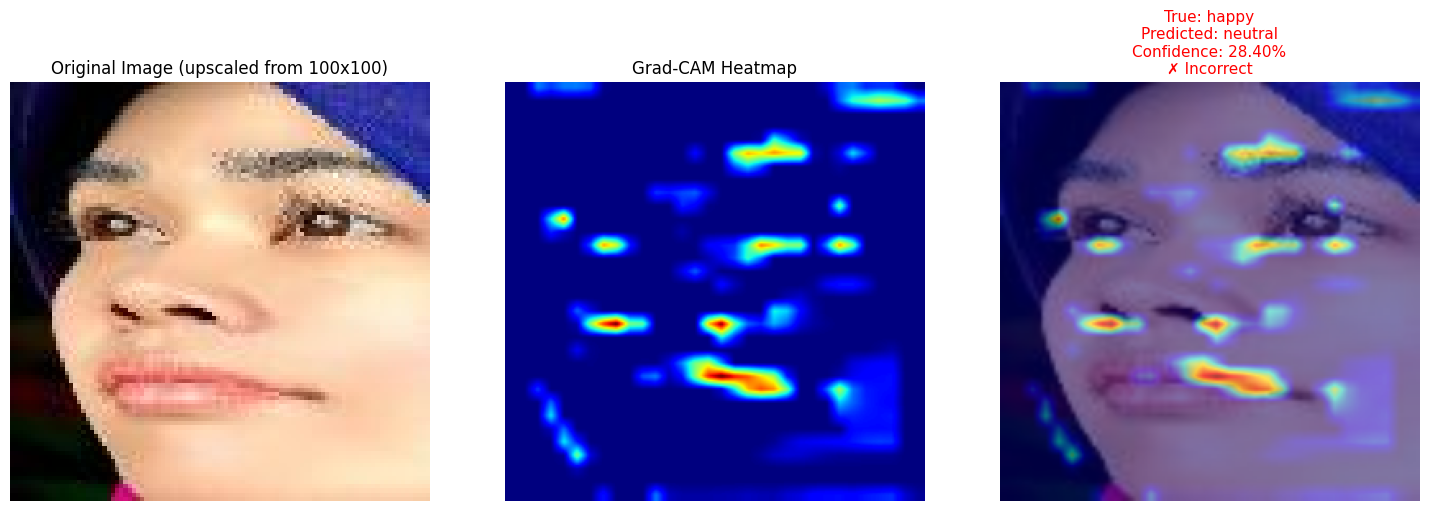


Predicted Emotion: neutral
Confidence: 28.40%


In [73]:
# 30 EPOCHS
# Convert emotion_names_list to list for indexing
emotion_names = list(dataset.emotion_map.values())

# Generate Grad-CAM for a test image
print("\n" + "=" * 60)
print("GENERATING GRAD-CAM VISUALIZATION")
print("=" * 60)

# Pick the first image from dataset
if len(dataset.images) > 0:
    test_image_path = dataset.images[2]

    emotion, confidence, cam = generate_emotion_cam(
        model=model,
        image_path=test_image_path,
        emotion_names=emotion_names,
        target_layer=model.conv4,  # Target the last conv layer for visualization
        true_label=dataset.labels[2],  # Provide true label for comparison
    )

    print(f"\nPredicted Emotion: {emotion}")
    print(f"Confidence: {confidence:.2%}")
else:
    print("No images found in dataset!")


GENERATING GRAD-CAM VISUALIZATION


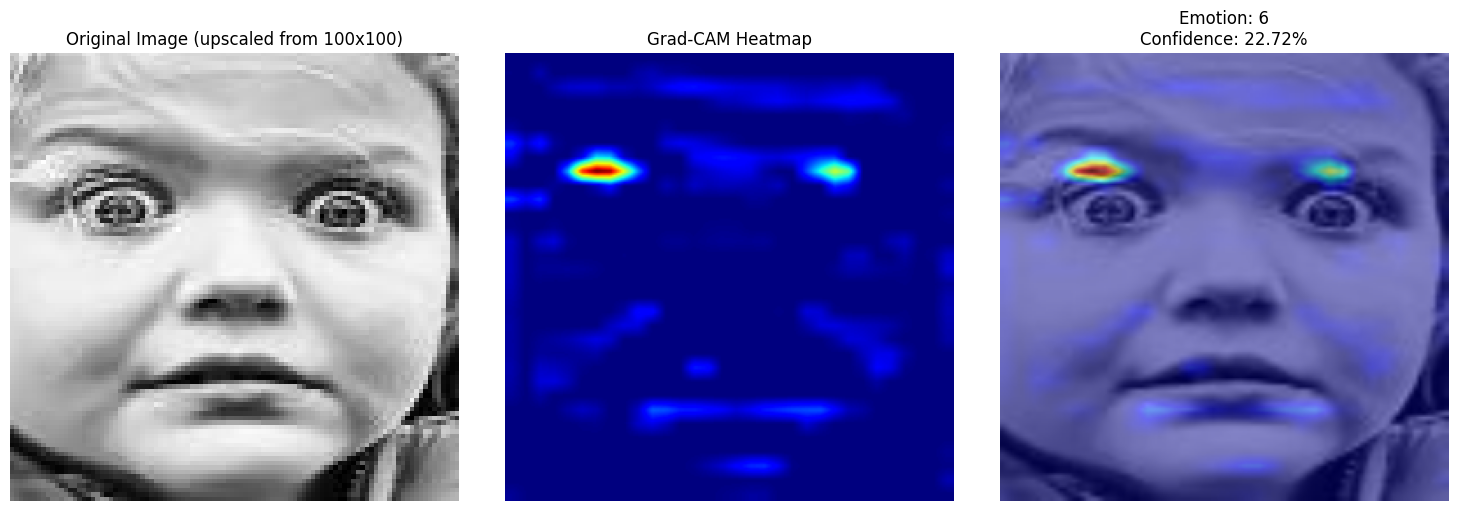


Predicted Emotion: 6
Confidence: 22.72%


In [41]:
# 15 EPOCHS
# Convert emotion_names_list to list for indexing
emotion_names = list(dataset.emotion_map.values())

# Generate Grad-CAM for a test image
print("\n" + "=" * 60)
print("GENERATING GRAD-CAM VISUALIZATION")
print("=" * 60)

# Pick the first image from dataset
if len(dataset.images) > 0:
    test_image_path = dataset.images[5]

    emotion, confidence, cam = generate_emotion_cam(
        model=model,
        image_path=test_image_path,
        emotion_names=emotion_names,
        target_layer=model.conv4,  # Target the last conv layer for visualization
    )

    print(f"\nPredicted Emotion: {emotion}")
    print(f"Confidence: {confidence:.2%}")
else:
    print("No images found in dataset!")


GENERATING GRAD-CAM VISUALIZATION


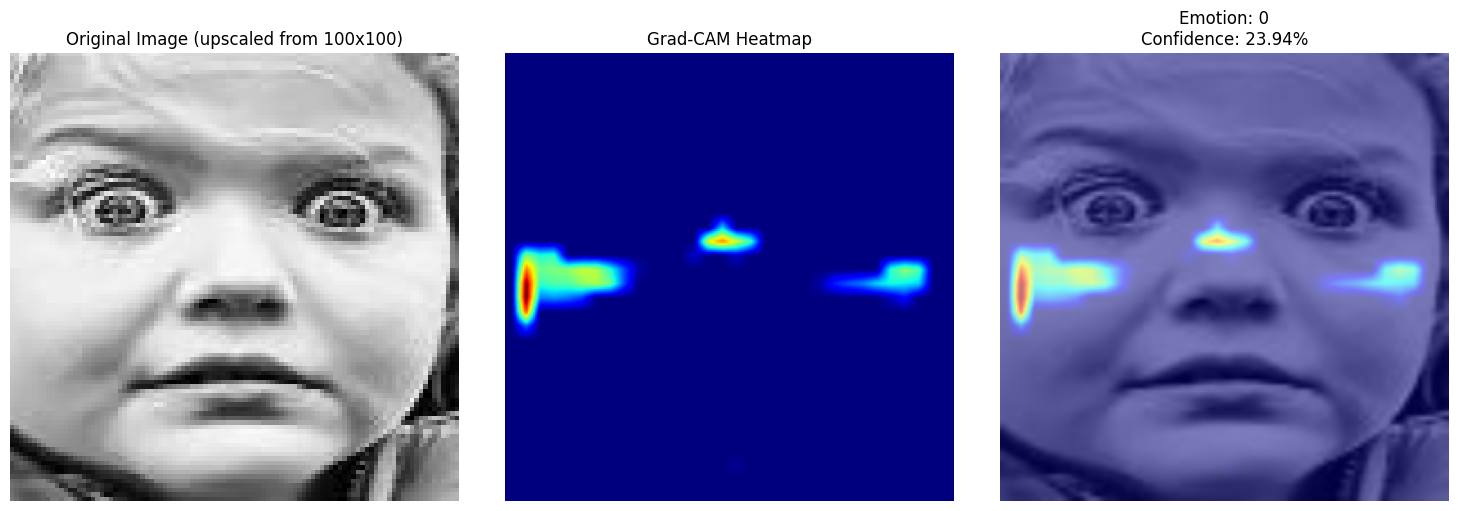


Predicted Emotion: 0
Confidence: 23.94%


In [34]:
# 5 EPOCHS
# Convert emotion_names_list to list for indexing
emotion_names = list(emotion_names_list.values())

# Generate Grad-CAM for a test image
print("\n" + "=" * 60)
print("GENERATING GRAD-CAM VISUALIZATION")
print("=" * 60)

# Pick the first image from dataset
if len(dataset.images) > 0:
    test_image_path = dataset.images[5]

    emotion, confidence, cam = generate_emotion_cam(
        model=model,
        image_path=test_image_path,
        emotion_names=emotion_names,
        target_layer=model.conv4,  # Target the last conv layer for visualization
    )

    print(f"\nPredicted Emotion: {emotion}")
    print(f"Confidence: {confidence:.2%}")
else:
    print("No images found in dataset!")